# Atividade 05

## Métodos de Classificação Baseados em Árvore

Juliano Kendyi Shinohara

#### Bibliotecas

In [7]:
import pandas as pd
import numpy as np
import functools
import seaborn as sns
import matplotlib.pyplot as plt

from utils import rejeitar_hip_nula, imprimir_estatisticas, calcular_estatisticas
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind_from_stats
from joblib import Parallel, delayed


#### Leitura CSV

In [8]:
df = pd.read_csv('Video_games_esrb_rating.csv')
df = df.drop('title', axis=1)

X = df.drop('esrb_rating', axis=1)
y = df['esrb_rating'].values

X.head()

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


#### PCA

PCA, ou Análise de Componentes Principais, é uma técnica estatística utilizada para redução de dimensionalidade e análise de dados. Com o objetivo de diminuir a sua dimensionalidade apenas para duas, será realizado o PCA.

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

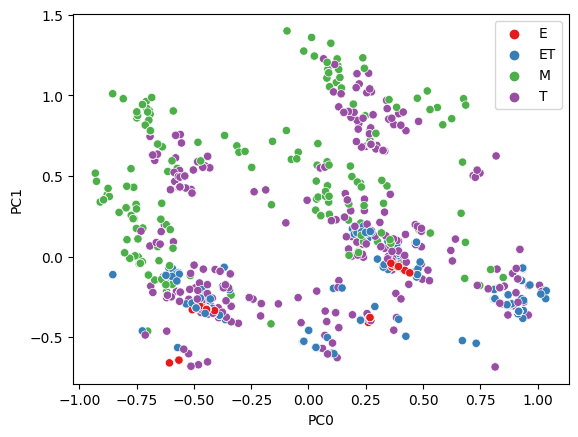

In [11]:
pca = PCA(n_components=2)

pca.fit(X)
X_pca = pca.transform(X)
X_pca_df = pd.DataFrame(X_pca, columns=['PC0', 'PC1'])

sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue=y, palette='Set1')

# def rejeitar_hip_nula(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2, alpha=0.05):
#     _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2)
#     return pvalor <= alpha

#### Treino e seleção do melhor modelo 

Para o treino dos classificadores, é utilizado o treinamento de segundo nivel para a atividade é utilizado 5 vias. Utilizando o GridSearchCV para determinar a melhhor métrica.

In [15]:
def selecionar_melhor_modelo(classificador, X_treino, X_val, y_treino, 
                             y_val, n_jobs=4, 
                             cv_folds=None, params={}):
    
    def treinar_modelo(X_treino, X_val, y_treino, y_val, params):
        clf = classificador(**params)
        clf.fit(X_treino, y_treino)
        pred = clf.predict(X_val)
        
        if len(set(y_treino)) > 2:
            return f1_score(y_val, pred, average='weighted')
        else:
            return f1_score(y_val, pred)
    
    
    if cv_folds is not None:
    
        #Se for pra usar validação cruzada, usar GridSearchCV
        score_fn = 'f1' if len(set(y_treino)) < 3 else 'f1_weighted'
        
        clf = GridSearchCV(classificador(), params, cv=cv_folds, n_jobs=n_jobs, scoring=score_fn)
        #Passar todos os dados (Treino e Validação) para realizar a seleção dos parâmetros.
        clf.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        
        melhor_comb = clf.best_params_
        melhor_val = clf.best_score_
        
    else:
        param_grid = list(ParameterGrid(params))
        
        f1s_val = Parallel(n_jobs=n_jobs)(delayed(treinar_modelo)
                                         (X_treino, X_val, y_treino, y_val, p) for p in param_grid)

        melhor_val = max(f1s_val)
        melhor_comb = param_grid[np.argmax(f1s_val)]
        
        clf = classificador(**melhor_comb)
        
        clf.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return clf, melhor_comb, melhor_val

#### Função para Validação cruzada

In [13]:
def do_cv(classificador, X, y, cv_splits, param_cv_folds=None,
         n_jobs=2, scale=False, params={}):
    
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    f1s = []
    predictions = []
    list_confusion_matrix = []
    list_melhor_comb = []
    
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)
        
        if scale:
            ss = StandardScaler()
            X_treino = ss.fit_transform(X_treino)
            X_teste = ss.transform(X_teste)
            X_val = ss.transform(X_val)        

        modelo, melhor_comb, _ = selecionar_melhor_modelo(classificador, X_treino, X_val, y_treino, y_val, 
                                                      n_jobs=n_jobs, cv_folds=param_cv_folds, params=params)
        pred = modelo.predict(X_teste)
        predictions.append(pred)

        print(classification_report(y_teste, pred))

        print(set(y_treino))
        
        if len(set(y_treino)) > 2:
            f1 = f1_score(y_teste, pred, average='weighted')
        else:
            f1 = f1_score(y_teste, pred)
        f1s.append(f1)
        
        print(f'{melhor_comb} -- F1-Score: {f1}')
        list_melhor_comb.append(melhor_comb)

        list_confusion_matrix.append(confusion_matrix(y_teste, pred))
        
        
    
    return f1s, list_confusion_matrix, list_melhor_comb

Para realizar o treino para o classificador DecisionTree é utilizado o número mínimo de folhas, números mínimos da divisão da árvore e a maxima profundidade da árvore.

In [45]:
resultados = {}
AccuracyDecisionTree, list_confusion_matrix, list_melhor_comb = do_cv(DecisionTreeClassifier, X_pca_df.values, y, 10, 5, 2, False,  {'min_samples_leaf' : [3, 5, 10, 15, 20, 30],
                    'min_samples_split' : [3, 5, 10, 15, 20, 30],
                    'max_depth' : [2, 3, 4, 5]})

              precision    recall  f1-score   support

           E       0.91      0.69      0.78        42
          ET       0.50      0.62      0.56        40
           M       0.65      0.62      0.63        39
           T       0.61      0.62      0.61        69

    accuracy                           0.64       190
   macro avg       0.67      0.64      0.65       190
weighted avg       0.66      0.64      0.64       190

{'E', 'T', 'ET', 'M'}
{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3} -- F1-Score: 0.6429391282853887
              precision    recall  f1-score   support

           E       0.77      0.95      0.85        42
          ET       0.81      0.75      0.78        40
           M       0.78      0.54      0.64        39
           T       0.69      0.74      0.71        69

    accuracy                           0.75       190
   macro avg       0.76      0.74      0.74       190
weighted avg       0.75      0.75      0.74       190

{'E', 'T', '

In [46]:
print("\n-------- DecisionTree --------\n- min: %.2f\n- max: %.2f\n- avg +- std: %.2f +- %.2f\n" % (min(AccuracyDecisionTree), max(AccuracyDecisionTree), np.mean(AccuracyDecisionTree), np.std(AccuracyDecisionTree)))

mediaArvDecisaotMelhor = np.mean(arvore_decisao[np.argmax(arvore_decisao)])
desvioArvDecisaoMelhor = np.std(arvore_decisao[np.argmax(arvore_decisao)])

mediaArvDecisaoPior = np.mean(arvore_decisao[np.argmin(arvore_decisao)])
desvioArvDecisaoPior = np.std(arvore_decisao[np.argmin(arvore_decisao)])

resultados['arvDecisao'] = AccuracyDecisionTree



-------- DecisionTree --------
- min: 0.64
- max: 0.74
- avg +- std: 0.70 +- 0.03



Após os resultados é realizado a soma das decisões utilizando o método "Reduce" da biblioteca "Functools" resultando no plot da matriz representando cada instância pertencente.

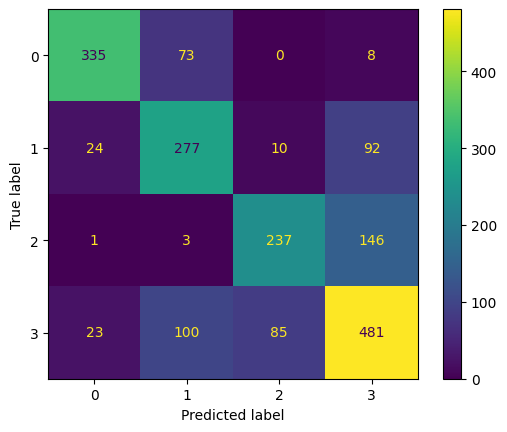

In [22]:
reduceMatrix = functools.reduce(lambda x,y :  x + y, list_confusion_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=reduceMatrix)
disp.plot()

Obtendo a melhor combinação dos hiperparâmetros para o desempenho utilizando o f1 score

In [24]:
melhor_comb = list_melhor_comb[np.argmax(arvore_decisao)]
print(f'Melhor combinação dos hiperparâmetros:\n {list_melhor_comb[np.argmax(arvore_decisao)]}')

Melhor combinação de hiperparâmetros:
 {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3}


#### DecisionTree

Obtendo a melhor combinação dos hiperparâmetros, é realizado o treino para o classificador de árvore de decisão.

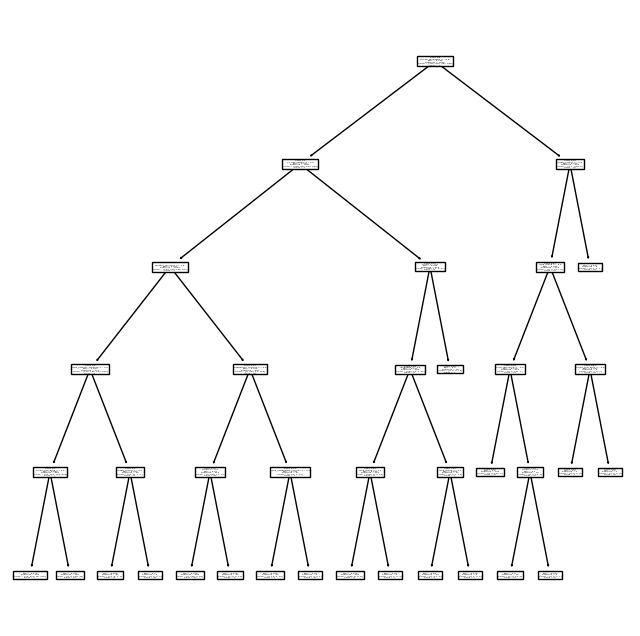

In [27]:
ad = DecisionTreeClassifier(**melhor_comb)
ad.fit(X, y)
plt.figure(figsize=(8,8))
plot_tree(ad, class_names=ad.classes_, feature_names=X.columns, node_ids=True)
plt.savefig('Arvore.svg')
plt.show()

#### Estrutura de regras de decisão

In [29]:
predClass = []

for linha in X.index:
    if X['strong_janguage'][linha] <= 0.5:

        if (X['no_descriptors'][linha] <= 0.5):
        
            if (X['fantasy_violence'][linha] <= 0.5):
        
                if (X['fantasy_violence'][linha] <= 0.5):
                    if (X['blood_and_gore'][linha] <= 0.5):
                        predClass.append('T')
                    else:
                        predClass.append('M')
                        
                else:
                    if(X['crude_humor'][linha] <= 0.5):
                        predClass.append('E')
                    else:
                        predClass.append('ET')

            else:
                if (X['suggestive_themes'][linha] <= 0.5): 
                    if (X['blood'][linha] <= 0.5):
                        predClass.append('ET')
                    else:
                        predClass.append('T')

                else:
                    if (X['mild_suggestive_themes'][linha] <= 0.5):
                        predClass.append('T')
                    else:
                        predClass.append('ET')

        else:
            if (X['blood'][linha] <= 0.5):
                if (X['language'][linha] <= 0.5):
                    if (X['mild_blood'][linha] <= 0.5):
                        predClass.append('E')
                    else:
                        predClass.append('T')
                    
                else:
                    if (X['mild_blood'][linha] <= 0.5):
                        predClass.append('T')
                    else:
                        predClass.append('T')

            else:
                predClass.append('T')
    else:
        if (X['crude_humor'][linha] <= 0.5):
            if (X['mild_blood'][linha] <= 0.5):
                if (X['drug_reference'][linha] <= 0.5):
                    predClass.append('T')
                else:
                    if (X['blood'][linha] <= 0.5):
                        predClass.append('M')
                    else:
                        predClass.append('M')

            else:
                if (X['blood_and_gore'][linha] <= 0.5):
                    predClass.append('T')
                else:
                    predClass.append('M')
            
        else:
            predClass.append('ET')
        

In [31]:
f1 = f1_score(y, predClass, average='weighted')
f1
print(f'Score para DecisionTree:\n\t {f1}')

Score para DecisionTree:
	 0.6298527781654958


#### Classificador Random Forest

In [47]:
AccuracyRandomForest, list_confusion_matrix_rf, list_melhor_comb = do_cv(RandomForestClassifier, X_pca_df.values, y, 10, 5, 2, False, {'n_estimators' : [100, 250, 500, 700]})
resultados['randomFor'] = AccuracyRandomForest

              precision    recall  f1-score   support

           E       0.97      0.90      0.94        42
          ET       0.76      0.78      0.77        40
           M       0.82      0.85      0.84        39
           T       0.77      0.78      0.78        69

    accuracy                           0.82       190
   macro avg       0.83      0.83      0.83       190
weighted avg       0.82      0.82      0.82       190

{'E', 'T', 'ET', 'M'}
{'n_estimators': 700} -- F1-Score: 0.8222025296337067
              precision    recall  f1-score   support

           E       0.95      0.95      0.95        42
          ET       0.84      0.78      0.81        40
           M       0.89      0.82      0.85        39
           T       0.79      0.86      0.82        69

    accuracy                           0.85       190
   macro avg       0.87      0.85      0.86       190
weighted avg       0.86      0.85      0.85       190

{'E', 'T', 'ET', 'M'}
{'n_estimators': 700} -- F1-Scor

In [48]:
print("\n-------- RANDOM FOREST --------\n- min: %.2f\n- max: %.2f\n- avg +- std: %.2f +- %.2f\n" % (min(AccuracyRandomForest), max(AccuracyRandomForest), np.mean(AccuracyRandomForest), np.std(AccuracyRandomForest)))


-------- RANDOM FOREST --------
- min: 0.77
- max: 0.87
- avg +- std: 0.83 +- 0.03



#### Classificador SVM

In [38]:
accuracySVM, list_confusion_matrix_svm, list_melhor_comb = do_cv(SVC, X_pca_df.values, y, 10, 5, 2, False, {'gamma' : ['auto', 'scale', 2e-2, 2e-3, 2e-4],
                'C' : [1, 10, 100, 1000], 'kernel': ['rbf']})

resultados['svm'] = accuracySVM

              precision    recall  f1-score   support

           E       0.79      0.98      0.87        42
          ET       0.74      0.57      0.65        40
           M       0.83      0.64      0.72        39
           T       0.66      0.74      0.70        69

    accuracy                           0.74       190
   macro avg       0.76      0.73      0.74       190
weighted avg       0.74      0.74      0.73       190

{'E', 'T', 'ET', 'M'}
{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'} -- F1-Score: 0.7316849465650478
              precision    recall  f1-score   support

           E       0.82      1.00      0.90        42
          ET       0.82      0.70      0.76        40
           M       0.90      0.72      0.80        39
           T       0.76      0.81      0.78        69

    accuracy                           0.81       190
   macro avg       0.83      0.81      0.81       190
weighted avg       0.82      0.81      0.81       190

{'E', 'T', 'ET', 'M'}
{'C': 1

In [39]:
print("\n-------- SVM --------\n- min: %.2f\n- max: %.2f\n- avg +- std: %.2f +- %.2f\n" % (min(accuracySVM), max(accuracySVM), np.mean(accuracySVM), np.std(accuracySVM)))


-------- SVM --------
- min: 0.70
- max: 0.81
- avg +- std: 0.76 +- 0.04



#### Classificador KNN

In [40]:
ks = list(range(1,30,2))
accuracyKNN, list_confusion_matrix_knn, list_melhor_comb = do_cv(KNeighborsClassifier, X_pca_df.values, y, 10, 5, 2, False, {'n_neighbors' : ks})

resultados['knn'] = accuracyKNN

              precision    recall  f1-score   support

           E       0.85      0.93      0.89        42
          ET       0.73      0.80      0.76        40
           M       0.72      0.72      0.72        39
           T       0.77      0.68      0.72        69

    accuracy                           0.77       190
   macro avg       0.77      0.78      0.77       190
weighted avg       0.77      0.77      0.77       190

{'E', 'T', 'ET', 'M'}
{'n_neighbors': 7} -- F1-Score: 0.7662935310303731
              precision    recall  f1-score   support

           E       0.91      0.98      0.94        42
          ET       0.78      0.88      0.82        40
           M       0.81      0.77      0.79        39
           T       0.81      0.74      0.77        69

    accuracy                           0.83       190
   macro avg       0.83      0.84      0.83       190
weighted avg       0.83      0.83      0.82       190

{'E', 'T', 'ET', 'M'}
{'n_neighbors': 5} -- F1-Score: 0.8

In [51]:
print("\n-------- KNN --------\n- min: %.2f\n- max: %.2f\n- avg +- std: %.2f +- %.2f\n" % (min(accuracyKNN), max(accuracyKNN), np.mean(accuracyKNN), np.std(accuracyKNN)))



-------- KNN --------
- min: 0.75
- max: 0.85
- avg +- std: 0.80 +- 0.03



Observando todos os resultados obtemos:

In [50]:
print("\n-------- DecisionTree --------\n- min: %.2f\n- max: %.2f\n- avg +- std: %.2f +- %.2f\n" % (min(AccuracyDecisionTree), max(AccuracyDecisionTree), np.mean(AccuracyDecisionTree), np.std(AccuracyDecisionTree)))
print("\n-------- RANDOM FOREST --------\n- min: %.2f\n- max: %.2f\n- avg +- std: %.2f +- %.2f\n" % (min(AccuracyRandomForest), max(AccuracyRandomForest), np.mean(AccuracyRandomForest), np.std(AccuracyRandomForest)))
print("\n-------- SVM --------\n- min: %.2f\n- max: %.2f\n- avg +- std: %.2f +- %.2f\n" % (min(accuracySVM), max(accuracySVM), np.mean(accuracySVM), np.std(accuracySVM)))
print("\n-------- KNN --------\n- min: %.2f\n- max: %.2f\n- avg +- std: %.2f +- %.2f\n" % (min(accuracyKNN), max(accuracyKNN), np.mean(accuracyKNN), np.std(accuracyKNN)))



-------- DecisionTree --------
- min: 0.64
- max: 0.74
- avg +- std: 0.70 +- 0.03


-------- RANDOM FOREST --------
- min: 0.77
- max: 0.87
- avg +- std: 0.83 +- 0.03


-------- SVM --------
- min: 0.70
- max: 0.81
- avg +- std: 0.76 +- 0.04


-------- KNN --------
- min: 0.75
- max: 0.85
- avg +- std: 0.80 +- 0.03



#### Teste-T

Para aplicação do Teste-T com os resultados obtidos dos classificadores DecisionTree, RandomForest, SVM e KNN, afim de obter a diferença visível entre os classificadores. 

In [42]:
largura = max(map(len,resultados.keys()))+2
print(" " * largura , end="")
      
for t in resultados:
    print(t.center(largura), end='')
print()

for t in resultados:
    print(t.center(largura), end='')
    for t2 in resultados:
        d, p = rejeitar_hip_nula(resultados[t], resultados[t2], alpha=0.05)
        print(("%.05f%s" % (p, ' (*)' if d else '')).center(largura), end='')
    print()

             arvDecisao  randomFor      svm         knn     
 arvDecisao   1.00000   0.00000 (*) 0.00212 (*) 0.00000 (*) 
 randomFor  0.00000 (*)   1.00000   0.00013 (*) 0.03827 (*) 
    svm     0.00212 (*) 0.00013 (*)   1.00000   0.02178 (*) 
    knn     0.00000 (*) 0.03827 (*) 0.02178 (*)   1.00000   
